In [ ]:
#The datasets and the problem I took from kaggle
#If you want to access here's the link https://www.kaggle.com/competitions/nlp-getting-started/code?competitionId=17777&sortBy=scoreDescending

In [ ]:
import numpy as np
import pandas as pd
import os

In [26]:
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-8
my_number_of_epochs = 15
my_warmup = 3
my_mini_batch_size = 32

In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: NVIDIA GeForce GTX 1650
I will use the GPU: NVIDIA GeForce GTX 1650


In [4]:
updated_train=pd.read_csv("train.csv")
updated_test=pd.read_csv("test.csv")
updated_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)

    text=" ".join(text.split())
    return text

updated_train['text'] = updated_train['text'].apply(preprocess)
updated_test['text'] = updated_test['text'].apply(preprocess)
updated_train = updated_train[updated_train["text"]!='']

updated_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [7]:
updated_train = updated_train[["text","target"]]
updated_train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [8]:
len(updated_train)

7561

In [9]:
updated_train["target"].value_counts()

0    4314
1    3247
Name: target, dtype: int64

In [10]:
# Get the lists of texts and labels.
texts = updated_train.text.values
labels = updated_train.target.values

#take a look at the first 50 training examples
for n in range(50):
    print(texts[n], "(LABEL:", labels[n], ")")

our deeds are the reason of this earthquake may allah forgive us all (LABEL: 1 )
forest fire near la ronge sask canada (LABEL: 1 )
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected (LABEL: 1 )
13000 people receive wildfires evacuation orders in california (LABEL: 1 )
just got sent this photo from ruby alaska as smoke from wildfires pours into a school (LABEL: 1 )
rockyfire update california hwy 20 closed in both directions due to lake county fire cafire wildfires (LABEL: 1 )
flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas (LABEL: 1 )
im on top of the hill and i can see a fire in the woods (LABEL: 1 )
theres an emergency evacuation happening now in the building across the street (LABEL: 1 )
im afraid that the tornado is coming to our area (LABEL: 1 )
three people died from the heat wave so far (LABEL: 1 )
haha south tampa is getting flooded hah wait a second i li

In [17]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW #Huggingface transformer algorithms and pretrain weights.
                #Electra is selected here, its pretraining method is more advanced than BERT's MLM. AdamW is Adam with weight decay correction.
import torch
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2) #let's try out electra's base discriminator
model.cuda()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

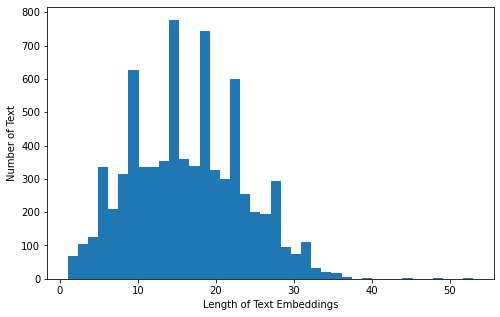

In [18]:
#histogram showing the length of text, text lengths in 40 bins
import matplotlib.pyplot as plt
def plot_sentence_text_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Text Embeddings");
    ax.set_ylabel("Number of Text");
    return
plot_sentence_text_length(texts, tokenizer)

In [20]:
indices=tokenizer.batch_encode_plus(texts,
                                    max_length=64,
                                    add_special_tokens=True,
                                    return_attention_mask=True,
                                    pad_to_max_length=True,
                                    truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [23]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = my_mini_batch_size

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = my_learning_rate, #args.learning_rate
                  eps = my_adam_epsilon  #args.adam_epsilon
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = my_number_of_epochs

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = my_warmup,
                                            num_training_steps = total_steps)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
import numpy as np

#about evalution mert - here we use accuracy, which is good enough because the data is
#is binary classified and distribution is pretty even between positive and negative
#however better evaluation should be use later F1 or AUC ROC because emergency are
#events rare tweets

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
import random

# Base on GLUE from huggingface, this is classification problem best suit our problem, here, look at the
# example Python code from hungingface gtihub, here is the here training loop

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        loss = outputs[0]

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 15 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:54.
  Batch   100  of    189.    Elapsed: 0:01:40.
  Batch   150  of    189.    Elapsed: 0:02:26.

  Average training loss: 0.63
  Training epoch took: 0:03:02

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:46.
  Batch   100  of    189.    Elapsed: 0:01:33.
  Batch   150  of    189.    Elapsed: 0:02:20.

  Average training loss: 0.48
  Training epoch took: 0:02:55

======== Epoch 3 / 15 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:46.
  Batch   100  of    189.    Elapsed: 0:01:31.
  Batch   150  of    189.    Elapsed: 0:02:17.

  Average training loss: 0.42
  Training epoch took: 0:02:53

======== Epoch 4 / 15 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:46.
  Batch   100  of    189.    Elapsed: 0:01:32.
  Batch   150  of    189.    Elapsed: 0:02:17.

  Average training loss: 0.40
  Training epoch took: 0:02:53

======== Ep

In [34]:
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:19


In [35]:
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [36]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       879
           1       0.78      0.79      0.78       634

    accuracy                           0.82      1513
   macro avg       0.81      0.81      0.81      1513
weighted avg       0.82      0.82      0.82      1513



In [38]:
text1 = updated_test.text.values

indices1=tokenizer.batch_encode_plus(text1,
                                     max_length=128,
                                     add_special_tokens=True,
                                     return_attention_mask=True,
                                     pad_to_max_length=True,
                                     truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.
batch_size = my_mini_batch_size

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

In [40]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None,
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()


  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [41]:
sample_sub=pd.read_csv('sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':flat_predictions})

In [42]:
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [46]:
df_leak = pd.read_csv('socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
updated_test = updated_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))

perfect_submission = pd.read_csv("sample_submission.csv")
perfect_submission['target'] = updated_test['target'].values
perfect_submission.to_csv('submission.csv',index=False)
perfect_submission.describe()

Leaked Data Set Shape = (10876, 2)
Leaked Data Set Memory Usage = 0.09 MB


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.429666
std,3146.427221,0.495104
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [47]:
perfect_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [48]:
perfect_submission.target.value_counts()

0    1861
1    1402
Name: target, dtype: int64